In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from TBGL_model import TwoBranchRegressor
from pcgrad import PCGrad

In [ ]:
device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:7


In [ ]:
mat1 = scipy.io.loadmat('train_data_0p5_partial.mat')
mat2 = scipy.io.loadmat('train_data_1p0_partial.mat')
X1 = mat1['matrix_input_all_n']
X2 = mat2['matrix_input_all_n']
Y2 = mat1['matrix_AREX_output_pcr']
R11 = mat1['R1W_cal_matrix_output_all_n']

# Targets
Y2 = Y2[:, 2:]
Y2[:, 0] *= 10000
Y2[:, 1] /= 10

# Inputs: 6.25 ppm to -6.25 ppm divided by R1obs
X1_n = X1[2:87,:].T / (R11)
X2_n = X2[2:87,:].T / (R11)

X_combined = np.stack([X1_n, X2_n],axis=1)
# Targets to tensors
B_np = Y2[:, 1]
A_np = Y2[:, 0]
B = torch.tensor(B_np, dtype=torch.float32).unsqueeze(1).to(device)
A = torch.tensor(A_np, dtype=torch.float32).unsqueeze(1).to(device)
print("Target tensor shapes:", A.shape, B.shape)
print("Device:", A.device)

# Dataset
X_tensor = torch.tensor(X_combined, dtype=torch.float32)
Y_tensor = torch.cat([A, B], dim=1)
dataset = TensorDataset(X_tensor, Y_tensor)

# Split
val_ratio = 0.2
val_size = int(len(dataset) * val_ratio)
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
print(f"Training samples: {train_size} | Validation samples: {val_size}")

Target tensor shapes: torch.Size([2187000, 1]) torch.Size([2187000, 1])
Device: cuda:7
Training samples: 1749600 | Validation samples: 437400


In [ ]:
def preprocess_input(x_tensor: torch.Tensor, add_noise: bool = False, noise_sd=None):
    """Prepare full and local inputs.

    Parameters
    ----------
    x_tensor : torch.Tensor
        Shape: (B, 2, 85)
    add_noise : bool
        If True, add Gaussian noise with std drawn from `noise_sd`.
    noise_sd : float | tuple[float, float] | None
        Scalar sigma, or (low, high) range. Required if add_noise=True.

    Returns
    -------
    full_input : torch.Tensor (6.25 to -6.25 ppm)
        (B, 2, 85)
    local_input : torch.Tensor (1.75 to 3.75 ppm)
        (B, 2, 17)  
    """
    x = x_tensor.clone()
    if add_noise:
        if noise_sd is None:
            raise ValueError("Provide noise_sd when add_noise=True")
        noise_level = (
            torch.empty(1).uniform_(*noise_sd).item()
            if isinstance(noise_sd, tuple) else noise_sd
        )
        noise = torch.randn_like(x) * noise_level
        x = x + noise

    x = x.float()
    full_input = x
    local_input = x[:, :, 14:31]
    return full_input, local_input

In [ ]:
regressor = TwoBranchRegressor().to(device)
optimizer = PCGrad(torch.optim.Adam(regressor.parameters(), lr=1e-4))

loss_fun = nn.MSELoss()
loss_den = nn.MSELoss()
lambda_denoise = 0.1
lambda_regress = 0.9
num_epochs = 100

In [ ]:
best_val_loss = float('inf')
patience = 5
patience_counter = 0

for epoch in range(num_epochs):
    regressor.train()
    total_loss_reg = 0.0
    total_loss_denoised_local = 0.0
    total_loss_denoised_global = 0.0

    for step, (data, target) in enumerate(train_loader):
        # data: [B, 2, 85]
        data = data.to(device)

        # Prepare inputs 
        full_input, clean_local = preprocess_input(data, add_noise=False)
        full_input_noisy, noisy_local = preprocess_input(
            data, add_noise=True, noise_sd=(0.001, 0.04)
        )

        full_input = full_input.to(device)          # [B,2,85]
        full_input_noisy = full_input_noisy.to(device)  # [B,2,85]
        clean_local = clean_local.to(device)        # [B,2,17]
        noisy_local = noisy_local.to(device)        # [B,2,17]

        # Targets
        target = target.to(device)
        A_t = target[:, 0].unsqueeze(1)
        B_t = target[:, 1].unsqueeze(1)

        optimizer.zero_grad()

        fs_pred, ksw_pred, denoised_local, denoised_global = regressor(full_input_noisy, noisy_local)

        # Regression losses
        loss_fs = loss_fun(fs_pred, A_t)
        loss_ksw = loss_fun(ksw_pred, B_t)
        loss_fsksw = loss_fun(fs_pred * ksw_pred, A_t * B_t)
        loss_reg = loss_fs + loss_ksw + loss_fsksw

        # Denoising losses
        loss_denoised_local  = loss_den(denoised_local,  clean_local)
        loss_denoised_global = loss_den(denoised_global, full_input)

        # PCGrad
        optimizer.pc_backward([
            lambda_denoise * loss_denoised_local,
            lambda_denoise * loss_denoised_global,
            lambda_regress * loss_reg,
        ])
        optimizer.step()

        total_loss_denoised_local += loss_denoised_local.item()
        total_loss_denoised_global += loss_denoised_global.item()
        total_loss_reg += loss_reg.item()

    # ----- Validation -----
    regressor.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_data, val_target in val_loader:
            val_data = val_data.to(device)
            val_full, val_local = preprocess_input(val_data, add_noise=False)
            val_full = val_full.to(device)
            val_local = val_local.to(device)
            
            val_target = val_target.to(device)
            A_val = val_target[:, 0].unsqueeze(1)
            B_val = val_target[:, 1].unsqueeze(1)

            Apred, Bpred, _, _ = regressor(val_full, val_local)
            val_loss += (
                loss_fun(Apred, A_val)
                + loss_fun(Bpred, B_val)
                + loss_fun(Apred * Bpred, A_val * B_val)
            ).item()

    avg_loss_reg = total_loss_reg / len(train_loader)
    avg_loss_local = total_loss_denoised_local / len(train_loader)
    avg_loss_global = total_loss_denoised_global / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    print(
        f"Epoch {epoch + 1:2d} | Regression Loss: {avg_loss_reg:.6f} | "
        f"Local Denoise Loss: {avg_loss_local:.6f} | Global Denoise Loss: {avg_loss_global:.6f} | "
        f"Validation Loss: {avg_val_loss:.6f}"
    )

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(regressor.state_dict(), 'best_model.pt')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

Epoch  1 | Regression Loss: 2249.006200 | Local Denoise Loss: 0.008511 | Global Denoise Loss: 0.002979 | Validation Loss: 2062.241687
Epoch  2 | Regression Loss: 2041.394334 | Local Denoise Loss: 0.010918 | Global Denoise Loss: 0.001368 | Validation Loss: 1451.337709
Epoch  3 | Regression Loss: 1839.525606 | Local Denoise Loss: 0.009580 | Global Denoise Loss: 0.001438 | Validation Loss: 1160.564231
Epoch  4 | Regression Loss: 1766.979839 | Local Denoise Loss: 0.005788 | Global Denoise Loss: 0.001275 | Validation Loss: 997.686915
Epoch  5 | Regression Loss: 1732.664614 | Local Denoise Loss: 0.003918 | Global Denoise Loss: 0.000919 | Validation Loss: 1044.484917
Epoch  6 | Regression Loss: 1694.992226 | Local Denoise Loss: 0.003150 | Global Denoise Loss: 0.000746 | Validation Loss: 891.684489
Epoch  7 | Regression Loss: 1604.999576 | Local Denoise Loss: 0.002718 | Global Denoise Loss: 0.000974 | Validation Loss: 801.077452
Epoch  8 | Regression Loss: 1481.960675 | Local Denoise Loss: 0.0

In [ ]:
#% load files
mat1 = scipy.io.loadmat('ALS_skeletal_muscle_data.mat')
DL_input = mat1['rat3']  # shape: [64, 64, 89, 2, 5]
R1W = mat1['rat3_R1map']  

output = np.zeros((64,64))

for i in range(64):
    for j in range(64):
        if R1W[i, j] == 0:
            output[i, j] = 0
        else:
            # Extract and flip both spectra 
            spec1 = np.flip(DL_input[i, j, :, 0],axis=0) # [85]
            spec1 = (spec1 - spec1[45,])/(1-spec1[45,])

            spec2 = np.flip(DL_input[i, j, :, 1],axis=0)  # [85]
            # Normalize both by R1
            R1_val = R1W[i, j]
            norm1 = spec1[2:87] / R1_val
            norm2 = spec2[2:87] / R1_val

            # Stack and convert to tensor: [1, 2, 85]
            dual_input = np.stack([norm1, norm2], axis=0)  # [2, 85]
            dual_tensor = torch.tensor(dual_input, dtype=torch.float32).unsqueeze(0).to(device)  # [1, 2, 85]

            # Run model
            with torch.no_grad():
                # Preprocess to get full_input and local_input
                full_input, noisy_local_test = preprocess_input(dual_tensor, add_noise=False)
                full_input = full_input.to(device)
                noisy_local_test = noisy_local_test.to(device)
                fs_pred, ksw_pred,_,_ = regressor(full_input, noisy_local_test)
            
            output[i,j] = np.abs(fs_pred.cpu().numpy().item())/10000

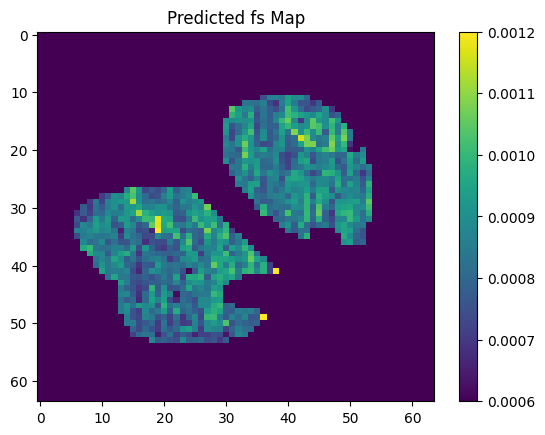

In [ ]:
plt.imshow(output, aspect='auto')
plt.clim(0.0006, 0.0012)
plt.colorbar()
plt.title('Predicted fs Map')
plt.show()

In [ ]:
#% load files
mat1 = scipy.io.loadmat('control_skeletal_muscle_data.mat')
DL_input = mat1['rat2']  # shape: [64, 64, 89, 2, 5]
R1W = mat1['rat2_R1map']  

output = np.zeros((64,64))

for i in range(64):
    for j in range(64):
        if R1W[i, j] == 0:
            output[i, j] = 0
        else:
            # Extract and flip both spectra 
            spec1 = np.flip(DL_input[i, j, :, 0],axis=0) # [85]
            spec1 = (spec1 - spec1[45,])/(1-spec1[45,])

            spec2 = np.flip(DL_input[i, j, :, 1],axis=0)  # [85]
            # Normalize both by R1
            R1_val = R1W[i, j]
            norm1 = spec1[2:87] / R1_val
            norm2 = spec2[2:87] / R1_val

            # Stack and convert to tensor: [1, 2, 85]
            dual_input = np.stack([norm1, norm2], axis=0)  # [2, 85]
            dual_tensor = torch.tensor(dual_input, dtype=torch.float32).unsqueeze(0).to(device)  # [1, 2, 85]

            # Run model
            with torch.no_grad():
                # Preprocess to get full_input and local_input
                full_input, noisy_local_test = preprocess_input(dual_tensor, add_noise=False)
                full_input = full_input.to(device)
                noisy_local_test = noisy_local_test.to(device)
                fs_pred, ksw_pred,_,_ = regressor(full_input, noisy_local_test)
            
            output[i,j] = np.abs(fs_pred.cpu().numpy().item())/10000

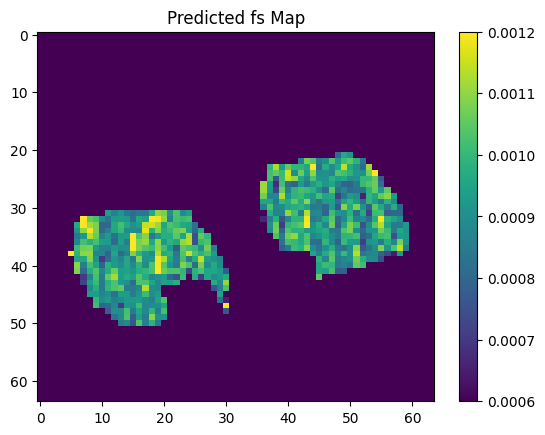

In [ ]:
plt.imshow(output, aspect='auto')
plt.clim(0.0006, 0.0012)
plt.colorbar()
plt.title('Predicted fs Map')
plt.show()